# LSTM for Time Series Prediction

This notebook illustrutes the time series prediction task using a Long Short Term Memory (LSTM) model implemented from scratch. 

The dataset used to train and evaluate the LSTM model is ......

In [40]:
import numpy as np
import pylab as plt
import jax
import jax.numpy as jnp
import re
import os
import pandas as pd
import pickle
import random
import string
from sklearn.model_selection import train_test_split

In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport model.lstm
%aimport model.helper

from model.lstm import Lstm
from model.helper import mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Processing

After downloading the raw data (of ... format), the [data processing notebook](/data_processing.ipynb) is used to parse data, select and encode features, and generate training, validation, testing set for the model.

In [42]:
# ....
# X_train, Y_train, X_val, Y_val, X_test, Y_test = [], [], [], [], [], []  # dummy place holder

# can print out example data for better understanding

## Experimental

test algo using ozone level detection first

The following are specifications for several most important attributes that are highly valued by Texas Commission on Environmental Quality (TCEQ). More details can be found in the two relevant papers.

- O3 - Local ozone peak prediction
- Upwind - Upwind ozone background level
- EmFactor - Precursor emissions related factor
- Tmax - Maximum temperature in degrees F
- Tb - Base temperature where net ozone production begins (50 F)
- SRd - Solar radiation total for the day
- WSa - Wind speed near sunrise (using 09-12 UTC forecast mode)
- WSp - Wind speed mid-day (using 15-21 UTC forecast mode)

In [43]:
# fetch dataset 
f = open('data/raw/eighthr.names', "r")
headers = f.read().split('\n')[2:]
headers = [header.split(':')[0] for header in headers]
headers[-1] = 'class'
df =  pd.read_csv('data/raw/eighthr.data', sep=",", names=headers)

from sklearn.impute import SimpleImputer
dates = df['Date'].to_numpy()
df.drop(columns='Date', inplace=True)
df.replace(to_replace='?', value=np.nan, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), dtype='float64')
df.columns = headers[1:]
df = df[headers[1:25]]
df=(df-df.mean())/df.std()

X = df.iloc[:, :-1].to_numpy()
Y = df.iloc[:, -1].to_numpy()
# Split the dataset into training and testing sets
split_train_index, split_val_index = int(X.shape[0] * 0.8), int(X.shape[0] * 0.7)
X_train, X_test, Y_train, Y_test = X[:split_train_index], X[split_train_index:], Y[:split_train_index], Y[split_train_index:]
X_train, X_val, Y_train, Y_val = X_train[:split_val_index], X_train[split_val_index:], \
    Y_train[:split_val_index], Y_train[split_val_index:]
Y_train, Y_val, Y_test = Y_train.astype(int)[:, jnp.newaxis], Y_val.astype(int)[:, jnp.newaxis], Y_test.astype(int)[:, jnp.newaxis]
num_features = X.shape[1]
X_train.shape, X_val.shape, X_test.shape

((1773, 23), (254, 23), (507, 23))

In [129]:
df_train, df_test = pd.read_csv('DailyDelhiClimateTrain.csv'), pd.read_csv('DailyDelhiClimateTest.csv')
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
train_dates, test_dates = df_train['date'].to_numpy(), df_test['date'].to_numpy()
df_train.drop(columns='date', inplace=True)
df_test.drop(columns='date', inplace=True)
df_train =(df_train - df_train.mean()) / df_train.std()
df_test =(df_test - df_test.mean()) / df_test.std()

# Min-max scaling function
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
df_train = sc.fit_transform(df_train)
df_test = sc.fit_transform(df_test)
df_train.shape, df_test.shape


((1462, 4), (114, 4))

In [140]:
n_timesteps = 1
X_train, Y_train = [], []
for i in range(0, df_train.shape[0], n_timesteps):
    if i + 2 * n_timesteps < df_train.shape[0]:
        X = df_train[i: i + n_timesteps, 1:]
        Y = df_train[i + n_timesteps: i + 2 * n_timesteps, 0]
        X_train.append(X)
        Y_train.append(Y)
X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
X_train.shape, Y_train.shape
split_index = int(X_train.shape[0] * 0.8)
X_train, Y_train, X_val, Y_val = X_train[:split_index], Y_train[:split_index], X_train[split_index:], Y_train[split_index:]

X_test, Y_test = [], []
for i in range(0, df_test.shape[0], n_timesteps):
    if i + 2 * n_timesteps < df_test.shape[0]:
        X = df_test[i: i + n_timesteps, 1:]
        Y = df_test[i + n_timesteps: i + 2 * n_timesteps, 0]
        X_test.append(X)
        Y_test.append(Y)
X_test, Y_test = jnp.array(X_test), jnp.array(Y_test)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((1168, 1, 3), (1168, 1), (292, 1, 3), (292, 1), (112, 1, 3), (112, 1))

## Model Training

The following cell initialize and runs the LSTM model on the processed data. 

In [141]:
# initialize hyperparameters
num_features = X_train.shape[-1]
input_dim, hidden_dim, output_dim = num_features + 8, 8, 1
num_epoches = 100
learning_rate = 0.05
batch_size = 4
# train model
model = Lstm(input_dim, hidden_dim, output_dim, num_epoches, learning_rate, batch_size)
model.train(X_train, Y_train, X_val, Y_val)
Y_test_pred = model.predict(X_test)

Start training ...
Epoch 1/100: training loss = 0.07684154063463211 | validation loss = 0.1344543993473053
Epoch 11/100: training loss = 0.05748504400253296 | validation loss = 0.10638415068387985
Epoch 21/100: training loss = 0.045942939817905426 | validation loss = 0.09287780523300171
Epoch 31/100: training loss = 0.03742945194244385 | validation loss = 0.08292394876480103
Epoch 41/100: training loss = 0.031048068776726723 | validation loss = 0.0753169134259224
Epoch 51/100: training loss = 0.026235925033688545 | validation loss = 0.06952114403247833
Epoch 61/100: training loss = 0.02261783741414547 | validation loss = 0.06526102870702744
Epoch 71/100: training loss = 0.019920580089092255 | validation loss = 0.06224025413393974
Epoch 81/100: training loss = 0.017932986840605736 | validation loss = 0.06015711650252342
Epoch 91/100: training loss = 0.01648678630590439 | validation loss = 0.05874653533101082


### Evaluation I: Mean Squared Error (MSE)

or use R^2 statistics or other metrics?

In [136]:
Y_test_pred = Y_test_pred.flatten()
Y_test = Y_test.flatten()
print(Y_test.shape, Y_test_pred.shape)

(80,) (80,)


In [137]:
print(f'Model prediction MSE = {mse(Y_test[:, jnp.newaxis], Y_test_pred[:, jnp.newaxis])}')

Model prediction MSE = 0.2544213533401489


### Evaluation 2: Line Plot

ValueError: x and y must have same first dimension, but have shapes (114,) and (80,)

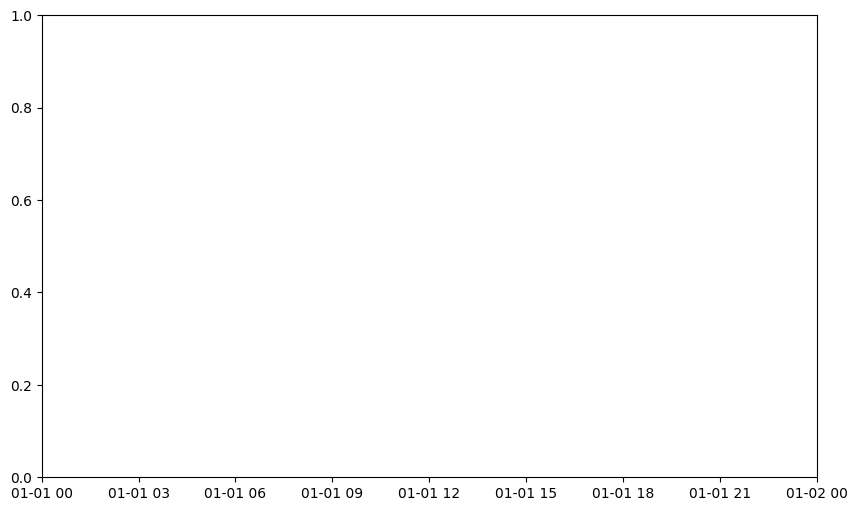

In [138]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_dates, Y_test, label='True',color='blue', linestyle='-')
plt.plot(test_dates, Y_test_pred, label='Pred',color='red', linestyle='-')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

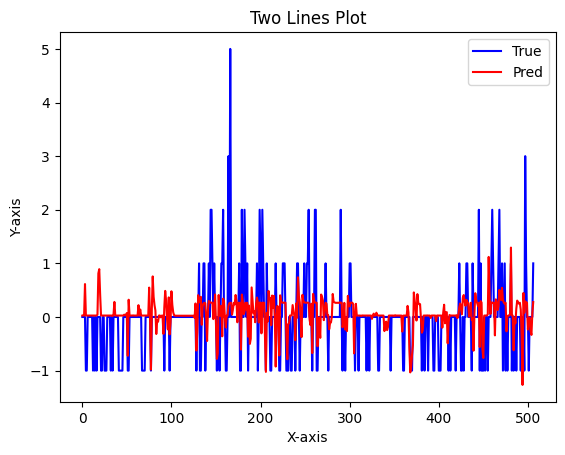

In [ ]:
plt.plot(Y_test, color='blue', label='True')
plt.plot(Y_test_pred, color='red', label='Pred')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Lines Plot')

# Add legend
plt.legend()

# Show plot
plt.show()

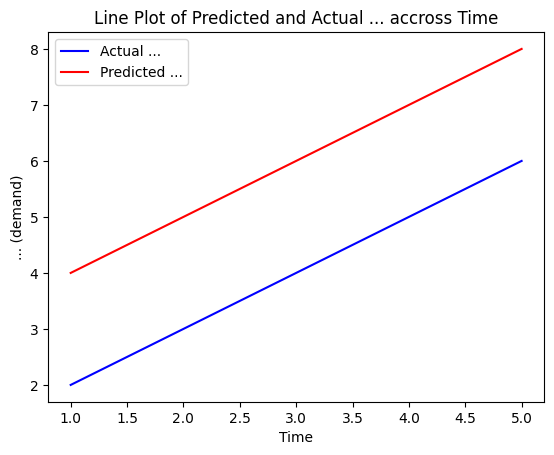

In [ ]:
import matplotlib.pyplot as plt

# to replace the points here with our (timestamp, predicted Y) series !!
points1 = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]
points2 = [(1, 4), (2, 5), (3, 6), (4, 7), (5, 8)]
x1, y1 = zip(*points1)
x2, y2 = zip(*points2)

plt.plot(x1, y1, color='blue', label='Actual ...')
plt.plot(x2, y2, color='red', label='Predicted ...')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('... (demand)')
plt.title('Line Plot of Predicted and Actual ... accross Time')
plt.legend()

# Show plot
plt.show()
